# Exercise 3: Distance->Connection probability of Inhibitory cells

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
In Workshop 2, we analyzed the relationship between distance between L3-IT neurons and their connectedness. Here, we will extend this analysis to other cell types, in particular inhibitory cells.

</div>

In [1]:
# Import packages
import sys
from os.path import join as pjoin
import platform

import itertools
import pandas as pd
import numpy as np
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)

from utils import filter_synapse_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Utility function to calculate distances
</div>

In [2]:
def calculate_lateral_distances(pre_cell_df, post_cell_df=None):
    """ Calculates the lateral distances in µm between all neurons."""
    if post_cell_df is None:
        post_cell_df = pre_cell_df
    
    pre_lateral_locations = np.array(pre_cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    post_lateral_locations = np.array(post_cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    lateral_distances = spatial.distance.cdist(pre_lateral_locations, post_lateral_locations)
    
    id_pairs = list(itertools.product(pre_cell_df["pt_root_id"], post_cell_df["pt_root_id"]))
    
    lateral_distance_df = pd.DataFrame(id_pairs, columns=['pre_pt_root_id', 'post_pt_root_id'])
    lateral_distance_df['distance'] = lateral_distances.flatten()

    lateral_distance_df = lateral_distance_df[lateral_distance_df['pre_pt_root_id'] != lateral_distance_df['post_pt_root_id']]
    return lateral_distance_df

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load synapse, proofreading and cell type information.
</div>

In [3]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

print(f'There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading')
print(f'The number of cells with usable axons and dendrites is: {len(np.isin(axon_proof_root_ids, dendrite_proof_root_ids))}')

There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1210


In [4]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [5]:
cell_df["cell_type"].value_counts()

cell_type
L6-CT    11260
L4-IT     7955
L3-IT     6361
L6-IT     6044
L5-IT     5090
L2-IT     3073
PTC       2951
L5-ET     2013
DTC       1933
ITC       1090
STC        723
L5-NP      699
Name: count, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Select an inhibitory subtype from the list above (recommend start: PTC) and plot the cell locations in the plane parallel to the cortical layers (as in the Workshop). Highlight the cells with proofread axons.

The cell type abbreviations are 

<ul>
  <li>PTC: Perisomatic targeting cells (e.g., basket cells)</li>
  <li>DTC: Distal dendrite targeting cells (e.g., somatostatin cells)</li>
  <li>STC: Sparse targeting cells (e.g., neurogliaform cells)</li>
  <li>ITC: Inhibitory targeting cells (e.g., bipolar cells)</li>
</ul>

See [Schneider-Mizell, et al., 2025](https://www.nature.com/articles/s41586-024-07780-8) for more details on these types.

</div>

In [6]:
sub_cell_df = cell_df[cell_df["cell_type"] == "PTC"]

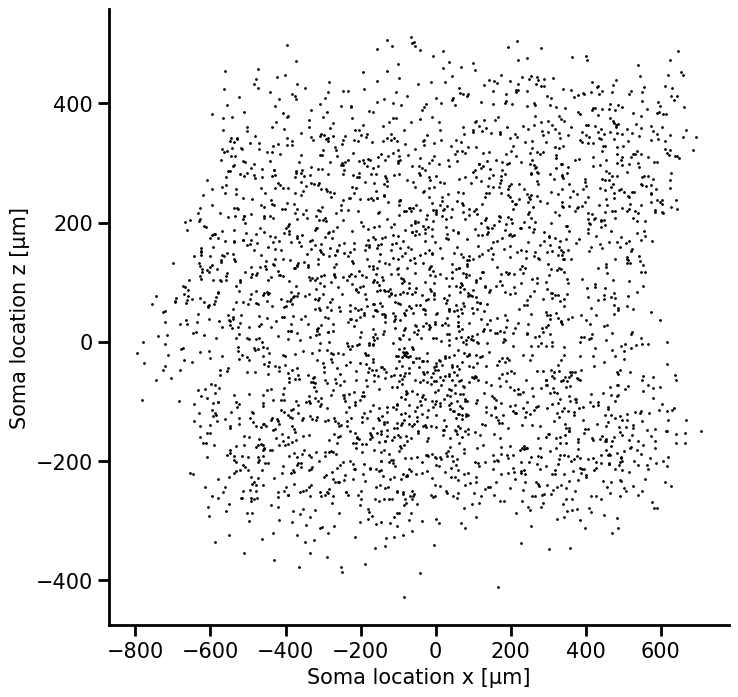

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Soma location x [µm]", fontsize=15)
ax.set_ylabel("Soma location z [µm]", fontsize=15)

plt.show()

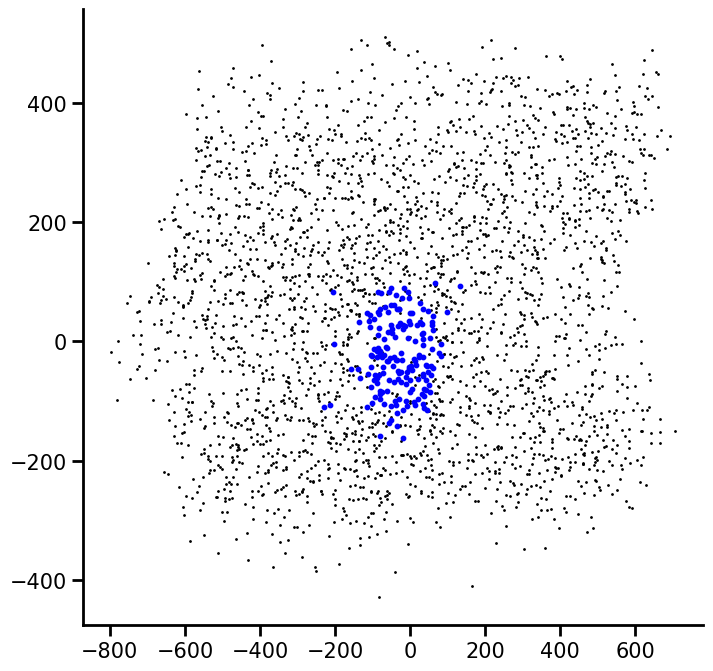

In [8]:
sub_cell_axon_proofread_df = sub_cell_df[np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data=sub_cell_df, x="pt_position_trform_x", y="pt_position_trform_z", c="k", s=1)
ax.scatter(data=sub_cell_axon_proofread_df, x="pt_position_trform_x", y="pt_position_trform_z", c="b", s=10)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Recretate the neuron-neuron distance histogram from the workshop for a different pair of cell types. In the workshop, we evaluated the distance-connectivity relation for potential connections from L3-IT cells to L3-IT cells. Here, recreate this analysis for PTCs to L3-IT cells. Create two separate "sub_cell_df". "calculate_lateral_distances" takes two dataframes (pre and post) and returns the distances between all possible pairs of pre and post cells. 

</div>

In [9]:
pre_sub_cell_df = cell_df[cell_df["cell_type"] == "PTC"]
pre_sub_cell_df = pre_sub_cell_df[np.isin(pre_sub_cell_df["pt_root_id"], axon_proof_root_ids)]

post_sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]
post_sub_cell_df = post_sub_cell_df[np.isin(post_sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

In [10]:
lateral_distance_df = calculate_lateral_distances(pre_sub_cell_df, post_sub_cell_df)

In [11]:
pre_root_ids = np.array(pre_sub_cell_df["pt_root_id"])
post_root_ids = np.array(post_sub_cell_df["pt_root_id"])

analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

In [12]:
conn_dist_df = pd.merge(conn_df, lateral_distance_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [13]:
lateral_distance_df

,pre_pt_root_id,post_pt_root_id,distance
0,864691132729533614,864691132654552792,236.428861
1,864691132729533614,864691132956447079,233.982511
2,864691132729533614,864691132726948075,311.640623
3,864691132729533614,864691132717799744,271.166413
4,864691132729533614,864691132656979312,156.010745
...,...,...,...
1094087,864691132579592205,864691132705099558,549.816085
1094088,864691132579592205,864691132760712071,373.290181
1094089,864691132579592205,864691132714342221,474.396134
1094090,864691132579592205,864691132799475421,265.576291


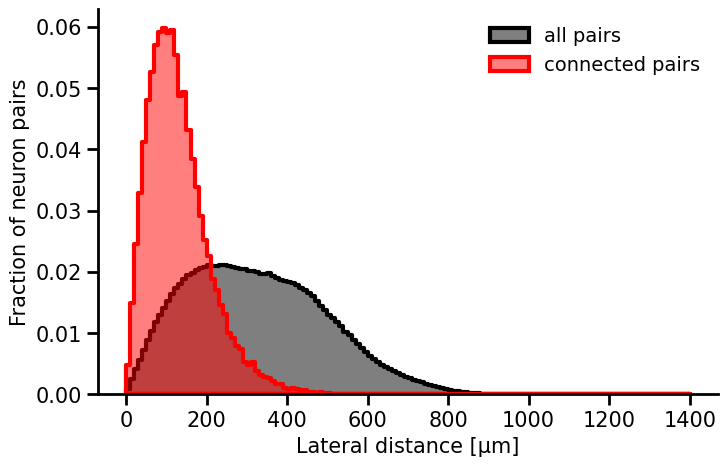

In [14]:
bins = np.linspace(0, 1400, 141)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, stat="proportion", x="distance", fill=True, bins=bins, alpha=.5, color="k", lw=3, element="step", label="all pairs")
sns.histplot(conn_dist_df, x="distance", stat="proportion", bins=bins, element="step", lw=3, fill=True, alpha=.5, color="r", label="connected pairs")
ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Convert the histograms into connection probabilities by dividing the counts (connected vs all) for each bin. Create a plot that shows Connection probability vs distance. 

</div>

In [15]:
bins = np.linspace(0, 500, 101) # 5µm bins

# Binned counts for proofread and connected pairs
proofread_pair_counts = np.histogram(lateral_distance_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

# Fraction of counts between connected and proofread pairs
connection_probability = connected_pair_counts / proofread_pair_counts
connection_probability_df = pd.DataFrame({"bin_id": np.arange(len(bins)-1), "probability": connection_probability})

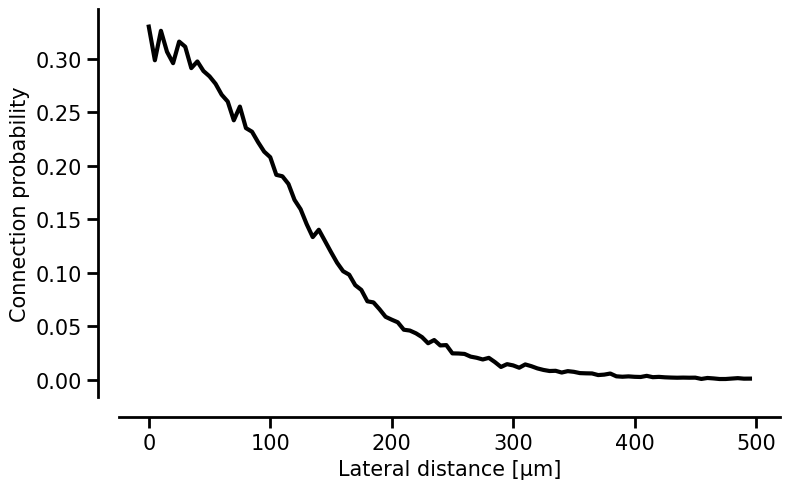

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<b> Task: </b> Repeat the analysis above for different cell types, e.g., switch from PTC to DTC. How does the plot above change?

</div>